In [1]:
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = '1'

In [2]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1)
train_generator = train_datagen.flow_from_directory('data/train',
                                                    target_size=(150, 150), 
                                                    batch_size=5,
                                                    class_mode='binary')

Found 160 images belonging to 2 classes.


In [3]:
test_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1)
test_generator = test_datagen.flow_from_directory('data/test',
                                                    target_size=(150, 150), 
                                                    batch_size=5,
                                                    class_mode='binary')

Found 120 images belonging to 2 classes.


In [4]:
transfer_model = VGG16(weights='imagenet', include_top=False,
                      input_shape=(150, 150, 3))
transfer_model.trainable = False
transfer_model.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [5]:
finetune_model = models.Sequential()
finetune_model.add(transfer_model)
finetune_model.add(layers.Flatten())
finetune_model.add(layers.Dense(64, activation='relu'))
finetune_model.add(layers.Dropout(0.5))
finetune_model.add(layers.Dense(1, activation='sigmoid'))

In [6]:
finetune_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 64)                524352    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 15,239,105
Trainable params: 524,417
Non-trainable params: 14,714,688
_________________________________________________________________


In [7]:
finetune_model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.0002), 
              metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [8]:
history = finetune_model.fit(train_generator, epochs=20,
                    validation_data=test_generator, callbacks=[early_stopping])

Epoch 1/20
32/32 [==============================] - 23s 691ms/step - loss: 0.6986 - accuracy: 0.5938 - val_loss: 0.5233 - val_accuracy: 0.8167
Epoch 2/20
32/32 [==============================] - 22s 701ms/step - loss: 0.5654 - accuracy: 0.7188 - val_loss: 0.4762 - val_accuracy: 0.8250
Epoch 3/20
32/32 [==============================] - 22s 682ms/step - loss: 0.4678 - accuracy: 0.8000 - val_loss: 0.4059 - val_accuracy: 0.8917
Epoch 4/20
32/32 [==============================] - 22s 679ms/step - loss: 0.3994 - accuracy: 0.8687 - val_loss: 0.3846 - val_accuracy: 0.8583
Epoch 5/20
32/32 [==============================] - 21s 678ms/step - loss: 0.3372 - accuracy: 0.8750 - val_loss: 0.3771 - val_accuracy: 0.8500
Epoch 6/20
32/32 [==============================] - 22s 696ms/step - loss: 0.3534 - accuracy: 0.8750 - val_loss: 0.3105 - val_accuracy: 0.9000
Epoch 7/20
32/32 [==============================] - 22s 706ms/step - loss: 0.3514 - accuracy: 0.8813 - val_loss: 0.2901 - val_accuracy: 0.9000

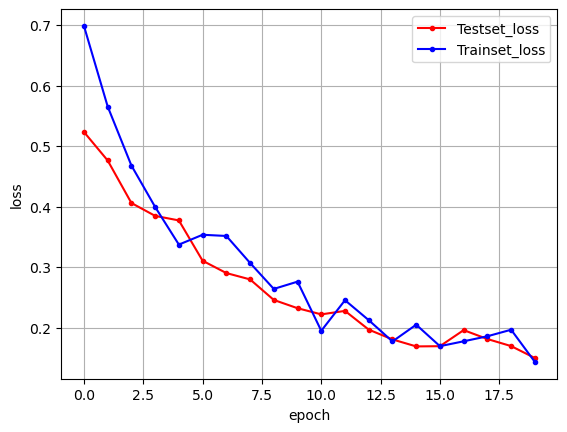

In [9]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 봅니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시하겠습니다.
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()